# Gravity Survey for Tunnel Detection
------------
* Due date: October 8, 2025

## Objectives

Our objectives are:
* Design and perform a surface gravity survey to detect the underground steam tunnel in front of the Green Center.


## Background
### Tunnels

In previous labs you have modeled the tunnels, the approximate range of gravity anomalies was between 30-80 microGal


## Task
Broadly your tasks involve three items:

### 1) Layout your survey
Setup and mark your survey locations on the ground.

### 2) Accurately measure the spatial locations
Using an appropriately accurate device, measure the station locations.

### 3) Measure Gravity
Using the gravimeters measure the anomaly of the tunnel. Remember to visit a base station often enough to accurately correct for instrument drift.

Afterwards, download the spatial and gravity data from the instruments.

# Lab 06 Writeup
### Lillian Hanson, Team 2, 10/08/2025

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from grav_utils.grav_interact import GravInteract
import math

### 2: Predicted Gravity Response:
Description of the predicted gravity response prior to survey that guided the data collection process.  A figure of the modeled/predicted data (using the code from last lab) with a descriptive caption.

WRITE AND ADD CODE HERE

### 3: Survey Predictions, Sketches
Description of the survey implemented in the field (survey length, number of stations, data separations, location relative to tunnels, etc.). A labeled graphic may be helpful to illustrate this.

The survey spanned 20 meters, 10 meters to each side from the center of the tunnel. It took ~160 minutes to complete. Group 2, the group I was in, denoted the survey placings with the center of the tunnel as 0, with values ranging to 10 m out on either side, the westward side (the side pointing to kafadar) being denoted as the negative axis. The graphic below shows the layout of the points where data was collected.  

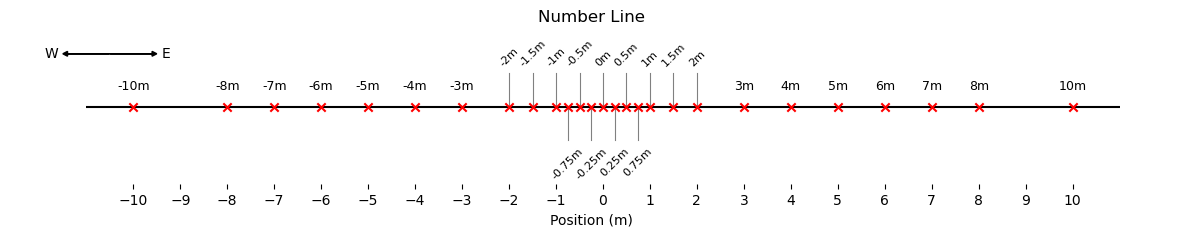

In [2]:
x_points = [-10, -8, -7, -6, -5, -4, -3, -2,
            -1.5, -1, -0.75, -0.5, -0.25, 0,
             0.25, 0.5, 0.75, 1, 1.5, 2,
             3, 4, 5, 6, 7, 8, 10]

plt.figure(figsize=(15, 2))
plt.hlines(0, min(x_points) - 1, max(x_points) + 1, colors='black')  # main line

# Plot 
plt.scatter(x_points, [0]*len(x_points), color='red', marker='x', zorder=3)

for x in x_points:
    # Points near zero 
    if -2 <= x <= 2:
        label_y = 0.35 if x % 0.5 == 0 else -0.35  
        plt.plot([x, x], [0, label_y], color='gray', lw=0.8, zorder=1)
        plt.text(x, label_y + (0.05 if label_y > 0 else -0.05),
                 f'{x}m', ha='center', va='bottom' if label_y > 0 else 'top',
                 fontsize=8, rotation=45)
    else:
        # Regular labels
        plt.text(x, 0.15, f'{x}m', ha='center', va='bottom', fontsize=9)

compass_x = min(x_points) - 0.5
compass_y = 0.55

plt.arrow(compass_x, compass_y, 1, 0, head_width=0.05, head_length=0.1,
          fc='black', ec='black', length_includes_head=True, zorder=4)
plt.arrow(compass_x, compass_y, -1, 0, head_width=0.05, head_length=0.1,
          fc='black', ec='black', length_includes_head=True, zorder=4)

plt.text(compass_x + 1.1, compass_y, 'E', ha='left', va='center', fontsize=10)
plt.text(compass_x - 1.1, compass_y, 'W', ha='right', va='center', fontsize=10)

# Styling
plt.yticks([])
plt.xticks(range(-10, 11, 1))
plt.xlabel('Position (m)')
plt.title('Number Line')
plt.grid(False)
plt.box(False)
plt.ylim(-0.8, 0.8)

plt.show()

### 4: Data Collected
Raw data with times (including base station) and standard deviations, as well as processed (drift and free-air corrected) field data you would use for interpretation.  
    Please include the following (where you should be including captions for each figure):
    * Plot of raw data (with SD error bars)
    * Plot of drift and free-air corrected data (with SD error bars)
    * Plot of drift, free-air, and simple Bouguer corrected data (with SD error bars)

In [3]:
loc_data = pd.read_csv('data/grp2/grp2-lab6.csv')

In [4]:
locdf = loc_data
loccols = ['STATION', 'Northing', 'Easting', 'ELEV', 'Notes']
locdf.columns = loccols[:len(locdf.columns)]

for col in ['Northing', 'Easting', 'ELEV']:
    if col in locdf.columns:
        locdf[col] = pd.to_numeric(locdf[col], errors = 'coerce')
locdf = locdf.drop(index = 15)

reorder = locdf.iloc[33:34]
locdf = locdf.drop(index = 34)
locdf_top = locdf.iloc[:24]
locdf_bottom = locdf.iloc[24:]

locdf = pd.concat([locdf_top, reorder, locdf_bottom]).reset_index(drop=True)

In [5]:
column_names = [
    "LINE","STATION","ALT","GRAV","SD","TILTX","TILTY","TEMP","TIDE",
    "DUR","REJ","TIME","DEC_TIME_DATE","TERRAIN","DATE"
]

dfcg5 = pd.read_csv('data/grp2/CG5-2.TXT', sep=r'\s+', skiprows=52, header=None, names=column_names)

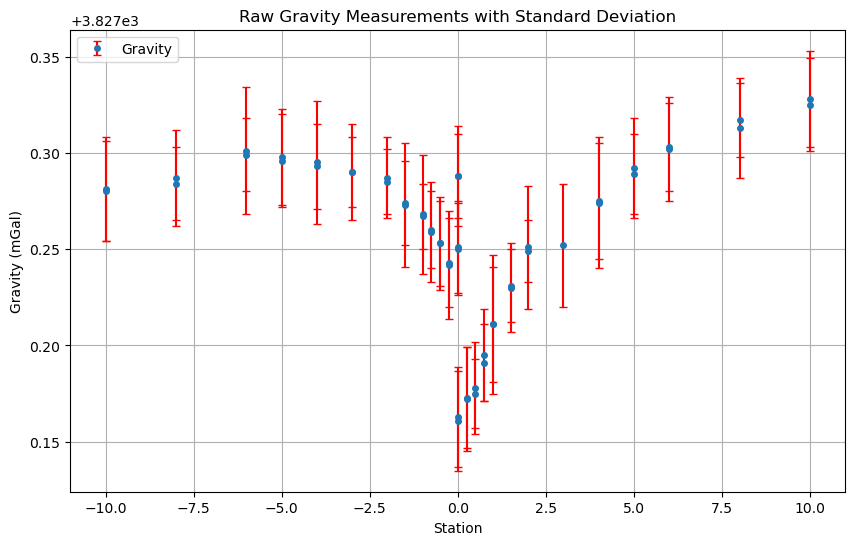

In [6]:
# Plot GRAV vs STATION with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(
    dfcg5['STATION'], dfcg5['GRAV'], yerr=dfcg5['SD'], 
    fmt='o', ecolor='red', capsize=3, markersize=4, label='Gravity'
)

plt.xlabel('Station')
plt.ylabel('Gravity (mGal)')
plt.title('Raw Gravity Measurements with Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
# clean columns
dfcg5['STATION'] = dfcg5['STATION'].astype(str).str.strip()
locdf['STATION'] = locdf['STATION'].astype(str).str.strip()

dfcg5['STATION_NUM'] = pd.to_numeric(dfcg5['STATION'], errors='coerce')
locdf['STATION_NUM'] = pd.to_numeric(locdf['STATION'], errors='coerce')

# merge data frames
df = pd.merge(dfcg5, locdf[['STATION_NUM', 'Northing', 'Easting', 'ELEV']],
              on='STATION_NUM', how='left')

df = df[['STATION_NUM', 'GRAV', 'Northing', 'Easting', 'TIME', 'ELEV', 'SD']]
df = df.sort_values('STATION_NUM')

# masks
is_base = (df['STATION_NUM'] == 0.00)
is_station = (df['STATION_NUM'] != 0.00)

# indices
base_inds = np.where(is_base)[0]
station_inds = np.where(is_station)[0]


times = pd.to_datetime(df['TIME'], format='%H:%M:%S')
print(len(times))
height = df['ELEV']
print(len(height))

53
53


In [73]:
# drift correction
obs = df['GRAV']

g_drift = np.interp(times, times[base_inds], obs[base_inds])
print(len(g_drift))

53


In [89]:
# free air correction
g_obs = df['GRAV']
g_fa = -0.3086 * height
print(len(g_fa))

53


53 53


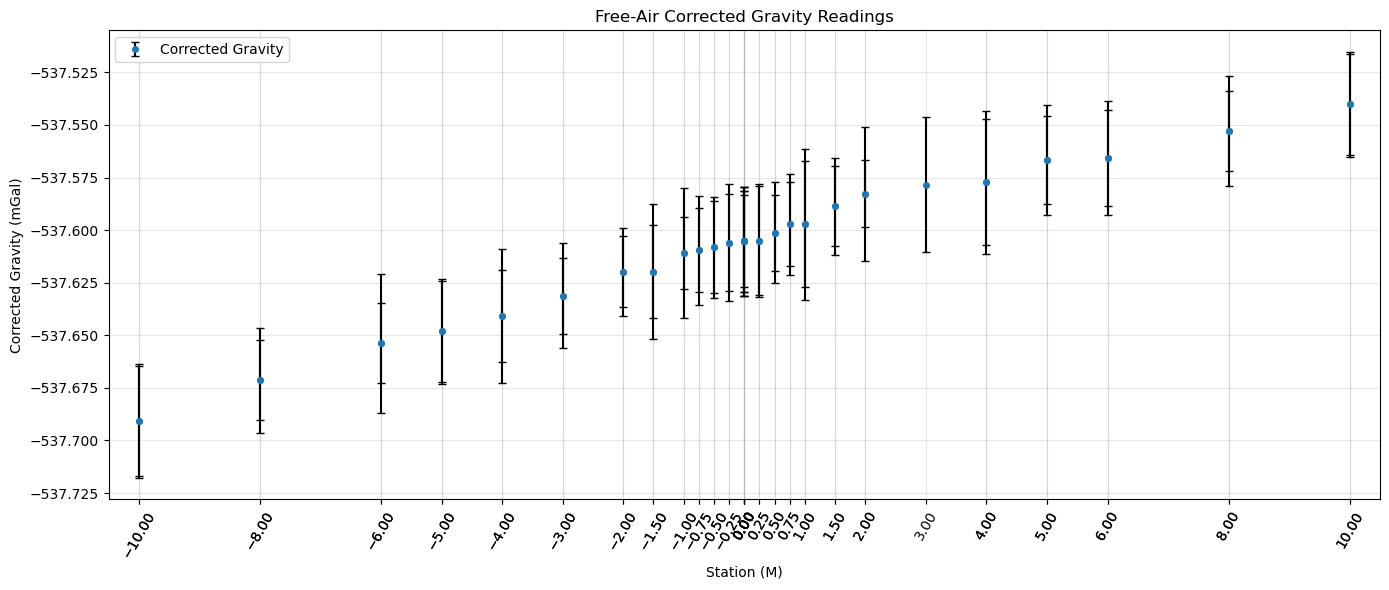

In [85]:
print(len(df['STATION_NUM']), len(g_fa))

# plot corrected gravity
plt.figure(figsize=(14, 6))
plt.errorbar(
    df['STATION_NUM'], 
    g_fa,
    yerr=df.get('SD'),
    fmt='o', ecolor='black', capsize=3, markersize=4, label='Corrected Gravity'
)

plt.xticks(df_sorted['STATION_NUM'], rotation=60)

plt.xlim(df_sorted['STATION_NUM'].min() - 0.5, df_sorted['STATION_NUM'].max() + 0.5)

plt.xlabel('Station (M)')
plt.ylabel('Corrected Gravity (mGal)')
plt.title('Free-Air Corrected Gravity Readings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

53 53


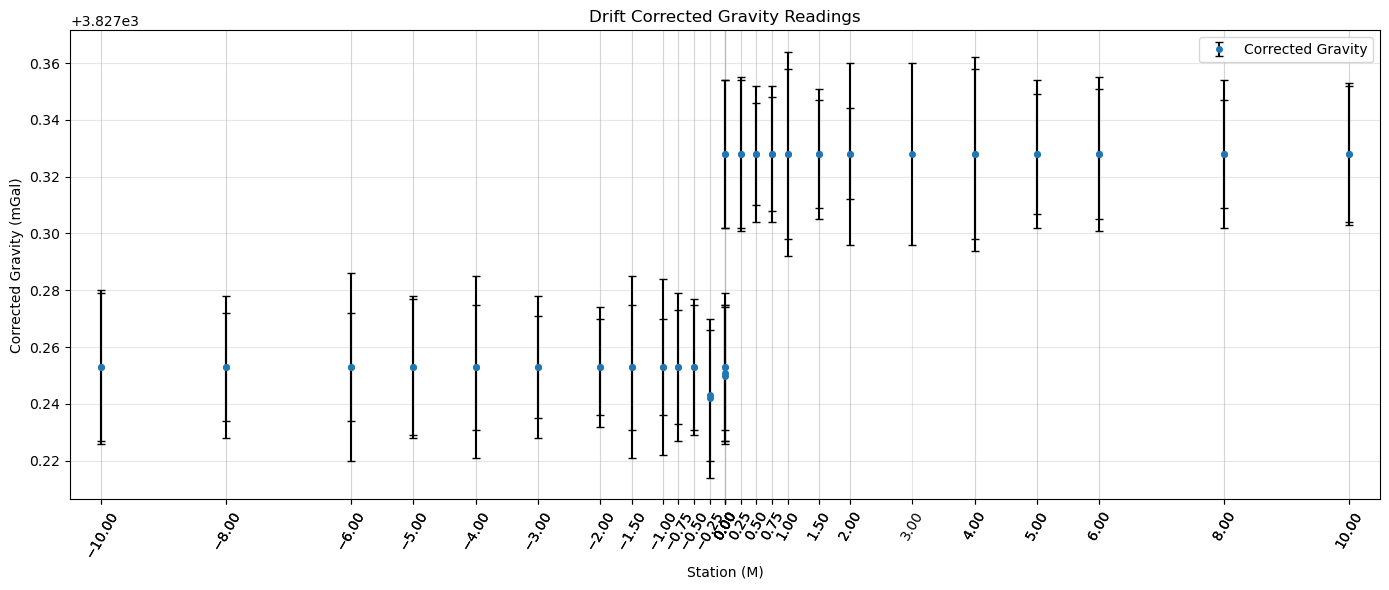

In [84]:
print(len(df['STATION_NUM']), len(g_fa))

# plot corrected gravity
plt.figure(figsize=(14, 6))
plt.errorbar(
    df['STATION_NUM'], 
    g_drift,
    yerr=df.get('SD'),
    fmt='o', ecolor='Black', capsize=3, markersize=4, label='Corrected Gravity'
)

plt.xticks(df_sorted['STATION_NUM'], rotation=60)

plt.xlim(df_sorted['STATION_NUM'].min() - 0.5, df_sorted['STATION_NUM'].max() + 0.5)

plt.xlabel('Station (M)')
plt.ylabel('Corrected Gravity (mGal)')
plt.title('Drift Corrected Gravity Readings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [97]:
# simple bouger correction

g_boog = 0.1119 * height

53 53


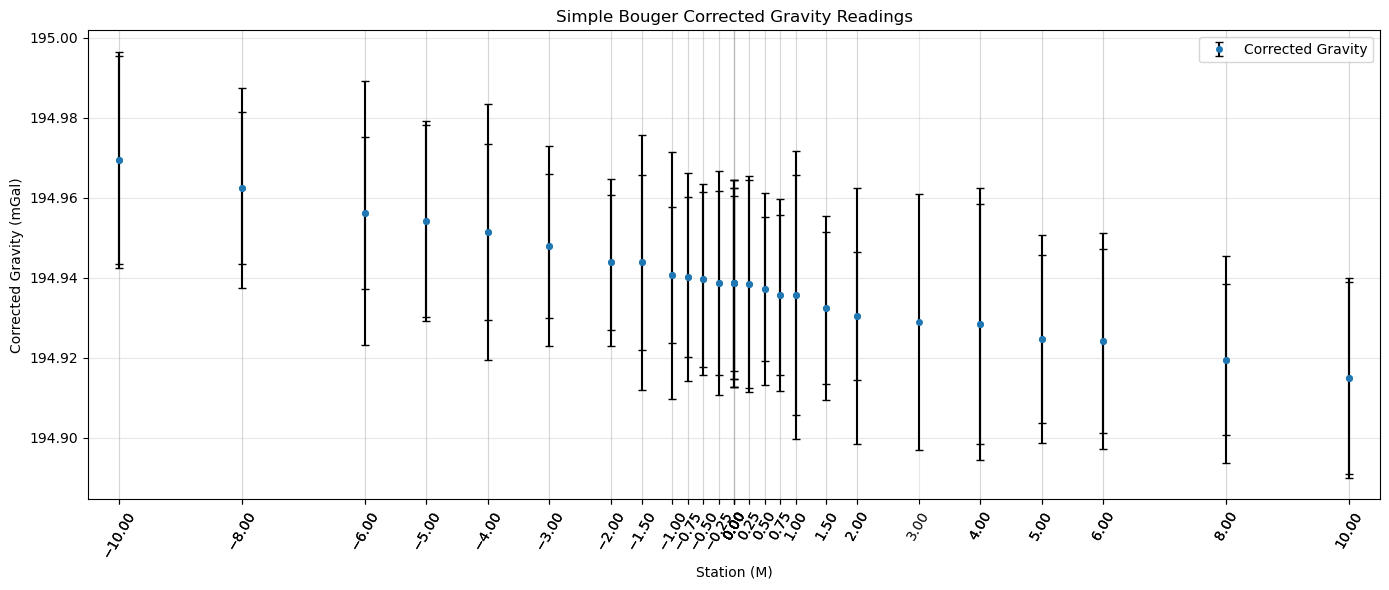

In [98]:
print(len(df['STATION_NUM']), len(g_fa))

# plot corrected gravity
plt.figure(figsize=(14, 6))
plt.errorbar(
    df['STATION_NUM'], 
    g_boog,
    yerr=df.get('SD'),
    fmt='o', ecolor='Black', capsize=3, markersize=4, label='Corrected Gravity'
)

plt.xticks(df_sorted['STATION_NUM'], rotation=60)

plt.xlim(df_sorted['STATION_NUM'].min() - 0.5, df_sorted['STATION_NUM'].max() + 0.5)

plt.xlabel('Station (M)')
plt.ylabel('Corrected Gravity (mGal)')
plt.title('Simple Bouger Corrected Gravity Readings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
# full corrected value
grav = g_obs - g_drift - g_fa - g_boog

53 53


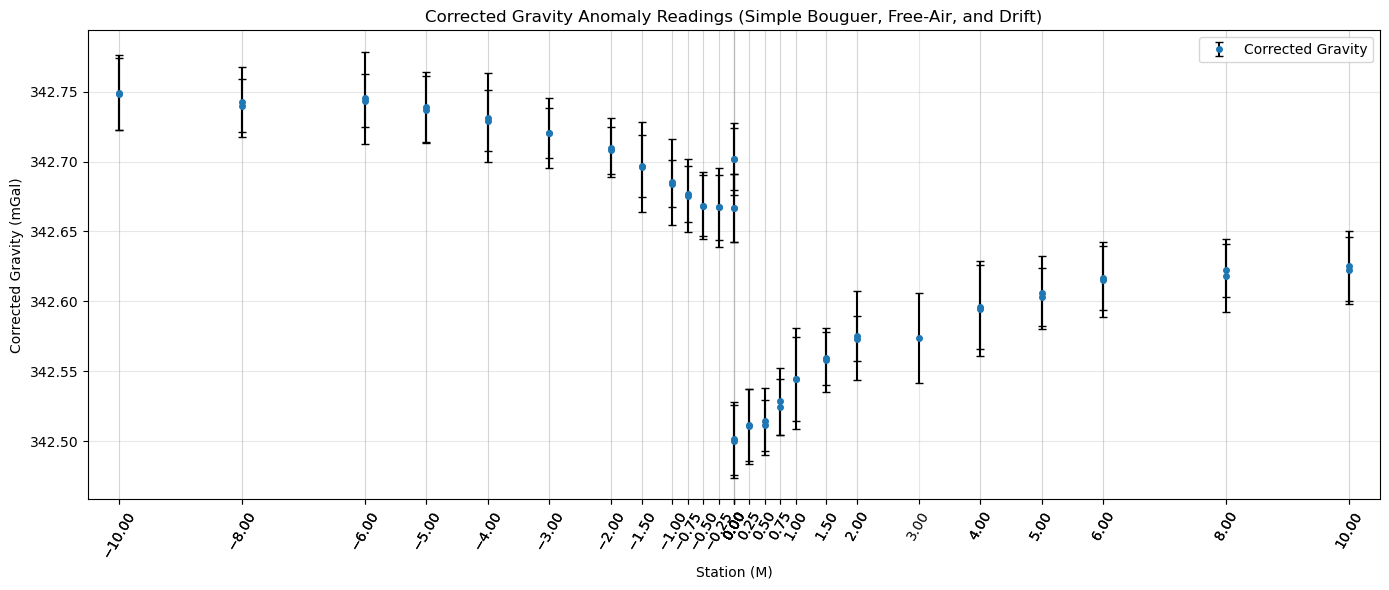

In [105]:
print(len(df['STATION_NUM']), len(g_fa))

# plot corrected gravity
plt.figure(figsize=(14, 6))
plt.errorbar(
    df['STATION_NUM'], 
    grav,
    yerr=df.get('SD'),
    fmt='o', ecolor='Black', capsize=3, markersize=4, label='Corrected Gravity'
)

plt.xticks(df_sorted['STATION_NUM'], rotation=60)

plt.xlim(df_sorted['STATION_NUM'].min() - 0.5, df_sorted['STATION_NUM'].max() + 0.5)

plt.xlabel('Station (M)')
plt.ylabel('Corrected Gravity (mGal)')
plt.title('Corrected Gravity Anomaly Readings (Simple Bouguer, Free-Air, and Drift)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### 5: Interpretations
A qualitative interpretation of field data (based on what you see visually in the measured gravity data, and relative to the forward models you performed in the previous labs).  
Address the following:
- Compare your response to the models of the tunnels generated in the previous lab.
- How does your model(s) compare to the data you collected?
- If any discrepancies exist, why?
- What parameters would you like more information about?

- dsf
- sdfs
- Discrepancies exist due to a number of factors.
- I would like more information about a more complex terrain correction

### 6: Improvements
 Very brief recommendation on how you would improve the survey if you had the opportunity to re-collect data over the tunnel.

If I had the opportunity to collect more data over the tunnel, the first change I would make would be using tape instead of chalk to mark survey locations so the locations couldn't be smudged or lost. I would also try to be more time-efficient for the sake of creating more closed loops in the survey to improve my accuracy. 

### 7: Adjustments
Assuming your geometry of the tunnels is correct, how would you adjust the density contrast of your model?